In [1]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sma
import pmdarima as pmd

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 150)

In [2]:
# data = yf.download(tickers='UBER', period='5d', interval='5m') ## dexample

### the real deal

In [3]:
# # data = yf.download(tickers='GME', period='5d', interval='5m')
# data = yf.download(tickers='GME', period='3d', interval='1m')

# data.index = pd.to_datetime(data.index)

In [4]:
# data.tail()

In [5]:
# fig, ax=plt.subplots(1,1,figsize=(12,6))
# # data[(data.index.hour >= 9) | (data.index.hour <= 16)]['Adj Close'].plot(ax=ax);
# ax.plot(data['Adj Close'].values);

In [6]:
# fig, ax=plt.subplots(1,1,figsize=(12,6))
# # data[(data.index.hour >= 9) | (data.index.hour <= 16)]['Volume'].plot(ax=ax);
# ax.plot(data.Volume.values);

In [7]:
# # data.head(150)
# gme = yf.Ticker("GME")

In [8]:
# gme.get_recommendations()

### long term

In [9]:
# lt = yf.download(tickers='GME', period='365d', interval='1d')

In [10]:
# lt.head()

In [11]:
# fig, ax=plt.subplots(1,1,figsize=(12,6))
# lt['Adj Close'].plot(ax=ax);

### nokia

In [12]:
nok = yf.download(tickers='NOK', period='183d', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [13]:
nok_ac = nok['Adj Close']
print(nok_ac.mean())

nok_model = sma.OLS(endog=nok_ac, exog=np.ones(nok_ac.shape)).fit()
nok_pred = pd.DataFrame(nok_model.predict(), index=nok_ac.index)

nok_ar = pmd.auto_arima(y=nok_ac, max_p=28, max_d=1, max_q=28, #seasonal = True, m=7, 
                        out_of_sample_size=14)
nok_ar_pred = pd.DataFrame(nok_ar.predict_in_sample(), index=nok_ac.index)

4.150847005062416


In [14]:
nok_forc = pd.DataFrame(nok_ar.predict(28),
                        index=pd.date_range(start=nok_ac.index[-1]+pd.offsets.Day(1), 
                                            freq='D', periods=28))

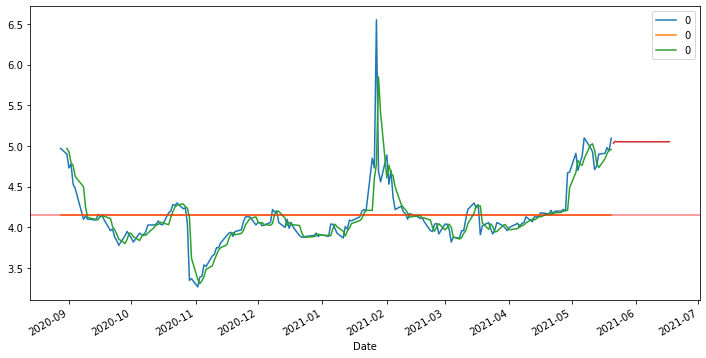

In [15]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
nok_ac.plot(ax=ax)
nok_pred.plot(ax=ax)
nok_ar_pred.iloc[1:].plot(ax=ax)
nok_forc.plot(ax=ax)
ax.axhline(nok_ac.mean(), c='r', alpha=0.5);

In [16]:
60*3.5*.2

42.0

### AMC GME Comparison

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


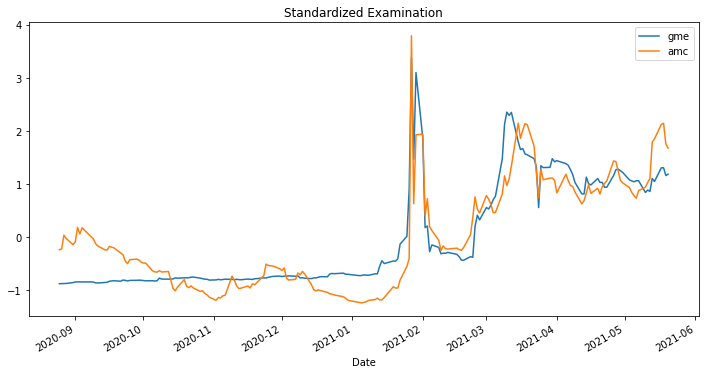

In [17]:
gme_6m = yf.download(tickers='GME', period='186d', interval='1d')
amc_6m = yf.download(tickers='AMC', period='186d', interval='1d')

ss = StandardScaler()
full = pd.concat([gme_6m['Adj Close'], amc_6m['Adj Close'], #nok_ac, 
                 ], axis=1)
full_ss = pd.DataFrame(ss.fit_transform(full.dropna()), index=gme_6m.index, 
                       columns=['gme','amc', #'nok',
                                ])

fig, ax=plt.subplots(1,1,figsize=(12,6))
full_ss.plot(ax=ax);
plt.title("Standardized Examination");


In [18]:
# gme_6m.Close

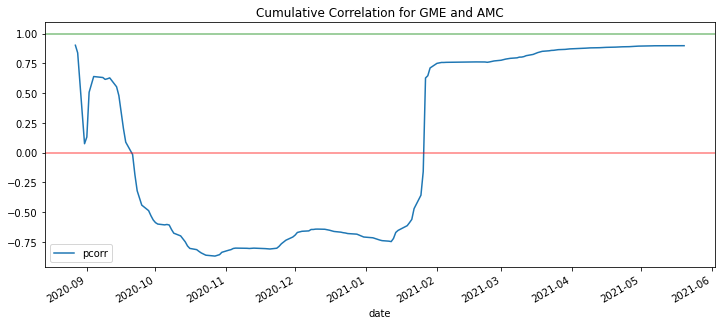

In [19]:
# full_ss.corr()

pcorrs = []
for idx in full_ss.index[2:]:
#     print("Corr Up to {}  =  {:.4f} ".format(idx, full_ss.loc[:idx].corr().values[0,1]))
    pcorrs.append([idx, full_ss.loc[:idx].corr().values[0,1]])

pcdf = pd.DataFrame(pcorrs, columns=['date','pcorr']).set_index('date')

fig, ax=plt.subplots(1,1,figsize=(12,5))
pcdf.plot(ax=ax);
ax.axhline(0,c='r',alpha=0.5);
ax.axhline(1,c='g',alpha=0.5);
ax.set_title("Cumulative Correlation for GME and AMC");

In [20]:
# nok_ar.summary()

### Fibonacci Retracements in Python

- https://blog.quantinsti.com/fibonacci-retracement-trading-strategy-python/
- https://towardsdatascience.com/fibonacci-retracements-in-python-470eb33b6362

In [22]:
# #============================================================
# highest_swing = -1
# lowest_swing = -1
# for i in range(1,df.shape[0]-1):
#     if df['High'][i] > df['High'][i-1] and df['High'][i] > df['High'][i+1] and (highest_swing == -1 or df['High'][i] > df['High'][highest_swing]):
#         highest_swing = i
#     if df['Low'][i] < df['Low'][i-1] and df['Low'][i] < df['Low'][i+1] and (lowest_swing == -1 or df['Low'][i] < df['Low'][lowest_swing]):
#         lowest_swing = i

# #============================================================
# ratios = [0,0.236, 0.382, 0.5 , 0.618, 0.786,1]
# colors = ["black","r","g","b","cyan","magenta","yellow"]
# levels = []
# max_level = df['High'][highest_swing]
# min_level = df['Low'][lowest_swing]
# for ratio in ratios:
#     if highest_swing > lowest_swing: # Uptrend
#         levels.append(max_level - (max_level-min_level)*ratio)
#     else: # Downtrend
#         levels.append(min_level + (max_level-min_level)*ratio)

# #============================================================

In [28]:
def analysis(ticker, period, interval, stma=True, start_date=None, figsize=(12,6)):
    item = yf.download(tickers=ticker, period=period, interval=interval)
    print(item.shape)
    if start_date is None:
        start_date = item.index[0]

    price_min = item.Close.min()
    price_max = item.Close.max()
    diff = price_max - price_min
    level1 = price_max - 0.236 * diff
    level2 = price_max - 0.382 * diff
    level3 = price_max - 0.618 * diff

    level_price = pd.DataFrame( columns = ['Level','Price'])
    level_price.loc["0.0"] = price_max
    level_price.loc["0.236"] = level1
    level_price.loc["0.382"] = level2
    level_price.loc["0.618"] = level3
    level_price.loc["1.0"] = price_min
    print(level_price)

    rolls = item.Close.rolling(20).mean().to_frame()
    rolls.columns = ['r20']
    rolls['r50'] = item.Close.rolling(50).mean()
    rolls['sign'] = np.sign(rolls.r50-rolls.r20)
    rolls['sign_s'] = rolls.sign.shift(1)
    rolls['intx'] = np.where(rolls.sign != rolls.sign_s, 1, 0)

    fig, ax=plt.subplots(1,1,figsize=(12,6))
    item.Close.loc[start_date:].plot(ax=ax, color='k')
    if stma == True:
        item.Close.rolling(20).mean().loc[start_date:].plot(ax=ax, style=['b:'])
        item.Close.rolling(50).mean().loc[start_date:].plot(ax=ax, style=['r:'])
        for idx in rolls[rolls.intx==1].loc[start_date:].index:
            ax.axvline(idx, color='k', alpha=0.5)
    ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
    ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
    ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
    ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')
#     ax.set_xticklabels(item.Close.index.values, {'fontsize':10, 'rotation':45})
    plt.title(ticker)
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(['Close Price','Short','Long'], loc=2);   
    
    return item

[*********************100%***********************]  1 of 1 completed
(365, 6)
          Level     Price
0.0    19.90000  19.90000
0.236  15.67088  15.67088
0.382  13.05456  13.05456
0.618   8.82544   8.82544
1.0     1.98000   1.98000


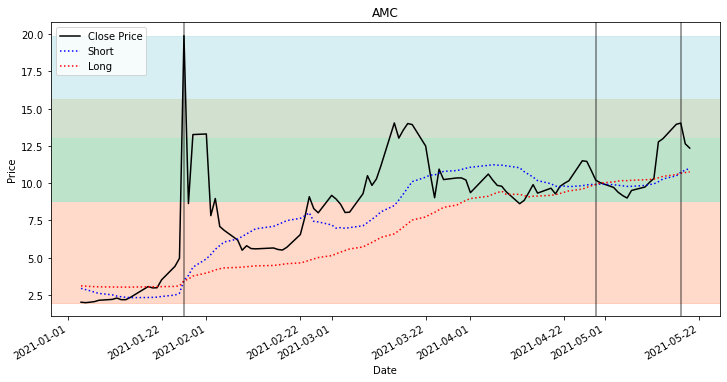

In [29]:
df = analysis('AMC', period='365d', interval='1d', start_date='2021-01-01')

- https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp#:~:text=Crossovers%20of%20the%2050%2Dday,.)%20to%20select%20moving%20averages.
- https://towardsdatascience.com/predicting-short-term-stock-movements-with-quantitative-finance-and-machine-learning-in-python-e6e04e3e0337

- When long crosses over short, SELL
- When short crosses over long, BUY
- 50 day by 10 or 20 are considered signifcant


- https://medium.com/coinmonks/legacy-banking-consumes-twice-as-much-energy-as-bitcoin-5b439fe10240

The first retracement level at 23.6% is \\$15.67, the second retracement level at 38.6\% is \\$13.05, and the next retracement level at 61.8\% is \\$8.82. 

**How to use the Fibonacci retracement trading strategy?**

The retracement levels can be used in a situation where you wanted to buy a particular stock but you have not been able to because of a sharp run-up in the stock price. In such a situation, wait for the price to correct to Fibonacci retracement levels such as 23.6\%, 38.2\%, and 61.8\% and then buy the stock.The ratios 38.2\% and 61.8\% are the most important support levels.

This Fibonacci retracement trading strategy is more effective over a longer time interval and like any indicator, using the strategy with other technical indicators such as RSI, MACD, and candlestick patterns can improve the probability of success.

**Should be below $8.82 to buy again.**

In [30]:
def weighted_mean(x,w):
    return np.sum(w*x)/np.sum(w)

In [31]:
amc_ap = np.array([15.95,8,10.72]) 
amc_shr = np.array([5,5,10]) 

amc_ap = np.array([15.95,8,10.72,9.90])
amc_shr = np.array([5,5,10,10])

amc_ap = np.array([15.95,8,10.72,9.90,9.89]) # 4.13.2021
amc_shr = np.array([5,5,10,10,5])

wt_prc = weighted_mean(amc_ap, amc_shr)
print("Current Avg Cost = ${:.2f}".format(wt_prc))

des_prc = 42 #18 #13.4

net = des_prc*amc_shr.sum() - wt_prc*amc_shr.sum()

print("Desired Return at ${:.2f} = ${:.2f}".format(des_prc, net))

print("Current Return = ${:.2f}".format( df.Close[-1]*amc_shr.sum() - wt_prc*amc_shr.sum()))

Current Avg Cost = $10.73
Desired Return at $42.00 = $1094.60
Current Return = $56.85


In [32]:
# import requests
# import json

# fgi = 'https://api.alternative.me/fng/?limit=0&format=csv&date_format=us'
# response = requests.get(fgi)
# # parsed = json.loads(response.text)
# print(response.text)


In [33]:
fgi = pd.read_csv('fgi.csv')
fgi.index = pd.to_datetime(fgi['date'])
fgi.sort_index(inplace=True)

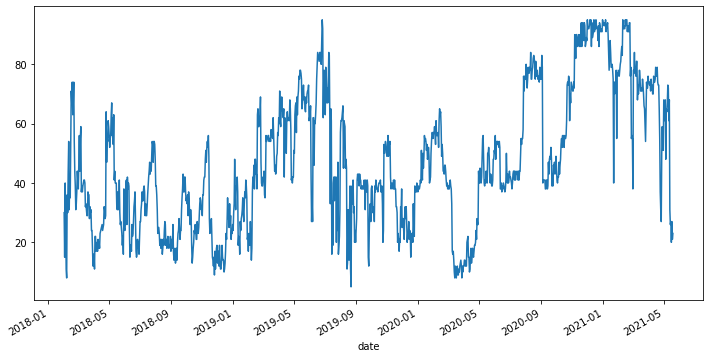

In [34]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
fgi.fng_value.plot(ax=ax);

### BITCOIN

[*********************100%***********************]  1 of 1 completed
(357, 6)
              Level         Price
0.0    63503.457031  63503.457031
0.236  50601.713617  50601.713617
0.382  42620.126590  42620.126590
0.618  29718.383176  29718.383176
1.0     8835.052734   8835.052734


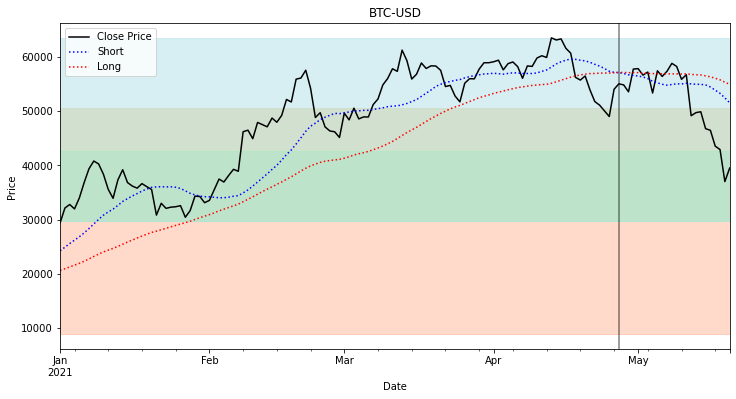

In [35]:
btc = analysis('BTC-USD','360d','1d',start_date='2021-01-01')

So by this estimate I should have sold a few days ago...

### DOGE

[*********************100%***********************]  1 of 1 completed
(357, 6)
          Level     Price
0.0    0.684777  0.684777
0.236  0.523715  0.523715
0.382  0.424074  0.424074
0.618  0.263012  0.263012
1.0    0.002309  0.002309


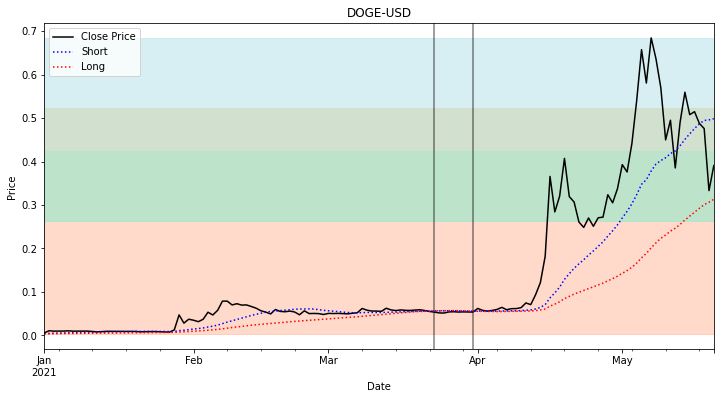

In [36]:
doge = analysis('DOGE-USD','360d','1d',start_date='2021-01-01')

### ADA

[*********************100%***********************]  1 of 1 completed
(357, 6)
          Level     Price
0.0    2.309113  2.309113
0.236  1.776772  1.776772
0.382  1.447442  1.447442
0.618  0.915101  0.915101
1.0    0.053430  0.053430


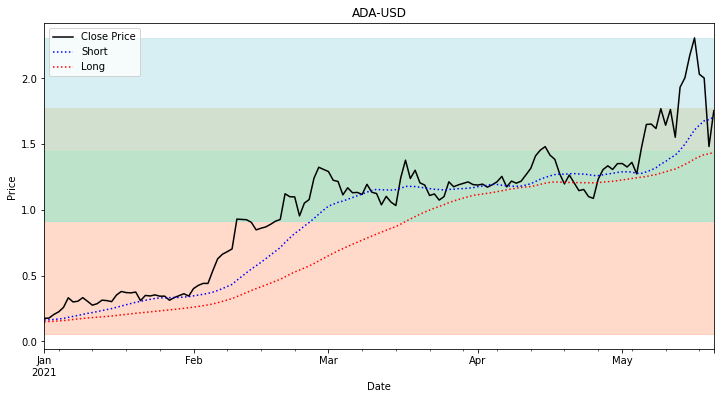

In [37]:
ada = analysis('ADA-USD','360d','1d',start_date='2021-01-01')

### ALGO

[*********************100%***********************]  1 of 1 completed
(333, 6)
          Level     Price
0.0    1.712424  1.712424
0.236  1.356430  1.356430
0.382  1.136196  1.136196
0.618  0.780202  0.780202
1.0    0.203974  0.203974


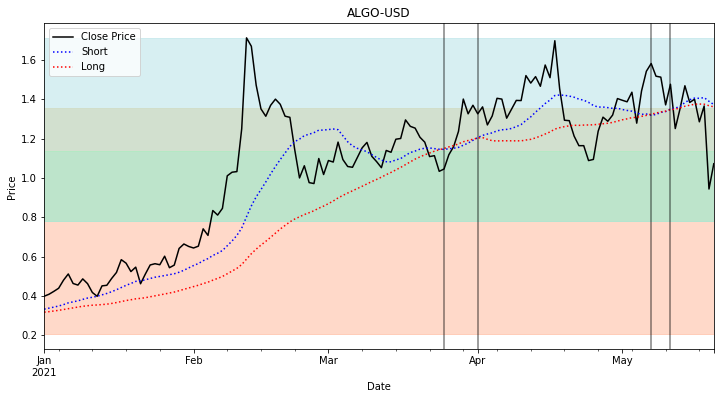

In [38]:
algo = analysis('ALGO-USD','360d','1d',start_date='2021-01-01')

### Fib on COIN

[*********************100%***********************]  1 of 1 completed
(27, 6)
            Level       Price
0.0    342.000000  342.000000
0.236  314.340801  314.340801
0.382  297.229601  297.229601
0.618  269.570402  269.570402
1.0    224.800003  224.800003


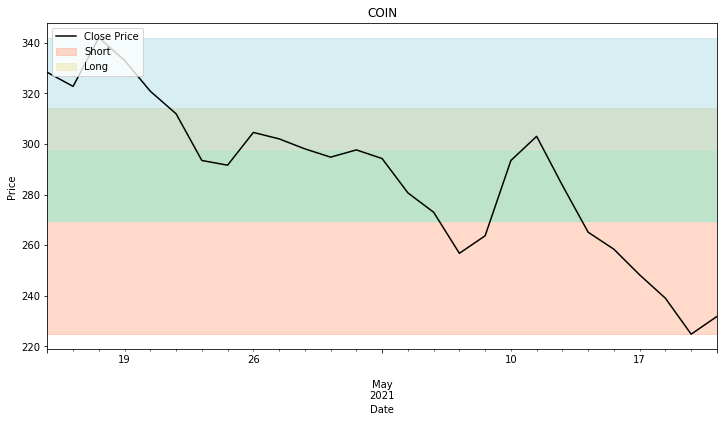

In [39]:
coin = analysis('COIN','60d','1d',stma=False,)

[*********************100%***********************]  1 of 1 completed
(30, 6)
         Level    Price
0.0    4.69000  4.69000
0.236  4.08584  4.08584
0.382  3.71208  3.71208
0.618  3.10792  3.10792
1.0    2.13000  2.13000


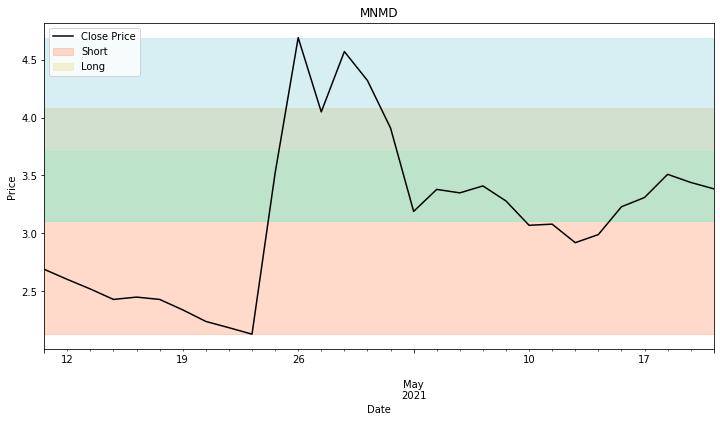

In [40]:
mnmd = analysis('MNMD', period='30d', interval='1d', stma=False)

In [41]:
# chk = yf.download(tickers='ADA', period='30d', interval='1d')

## ADA
market_cap = 55.7e9
total_locked_value = 

print("${:,.2f}".format(market_cap))

SyntaxError: invalid syntax (<ipython-input-41-89d9fcc8d7ab>, line 5)

### Fib on Roblox

[*********************100%***********************]  1 of 1 completed
(51, 6)
           Level      Price
0.0    82.050003  82.050003
0.236  77.790202  77.790202
0.382  75.154902  75.154902
0.618  70.895101  70.895101
1.0    64.000000  64.000000


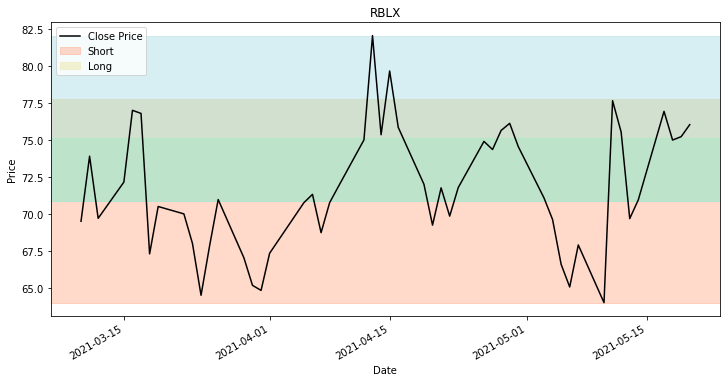

In [42]:
rblx = analysis('RBLX', period='60d', interval='1d', stma=False)

In [43]:
# bngo = yf.download(tickers='BNGO', period='186d', interval='1d')
# print(bngo.shape)

# price_min = bngo.Close.min()
# price_max = bngo.Close.max()

# diff = price_max - price_min
# level1 = price_max - 0.236 * diff
# level2 = price_max - 0.382 * diff
# level3 = price_max - 0.618 * diff

# print("Level", "Price")
# print("0 ", price_max)
# print("0.236", level1)
# print("0.382", level2)
# print("0.618", level3)
# print("1 ", price_min)

# fig, ax=plt.subplots(1,1,figsize=(12,6))
# bngo.Close.plot(ax=ax, color='k');
# ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
# ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
# ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
# ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')

# plt.ylabel("Price")
# plt.xlabel("Date")
# plt.legend(loc=2);